Notebook to train the ML models for sentiment analysis on vaccine text data by fetching the tweets. 
The models trained are the traditional Machine Learning(ML) models not any neural networks.

# Import packages

In [1]:
import os, pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter

import re
import emoji

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Load data

In [5]:
path = "data/Train.csv"
df_raw=pd.read_csv(path)
df_raw.shape

(10001, 4)

# Data Analysis

In [6]:
df_raw.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


The dataset has four columns. First being the tweet ID, safe_tet being the tweet, label is the sentiment of the tweet.<br>
Positive sentiment has label +1, neutral 0 and negative has label -1.

In [7]:
# total rows and columns in dataset
df_raw.shape

(10001, 4)

There are total 10001 rows and 4 columns

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


It shows that all columns have 10001 rows but "agreement" column has 2 null rows

In [9]:
# check programmatically null rows in dataset
df_raw.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [10]:
# drop the null rows and get the remaining rows as dataset
df2 = df_raw.dropna()
df2.shape

(9999, 4)

C:\Users\shahz\AppData\Local\Temp\ipykernel_3436\502813457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = df2['label'].map(label_mapping)


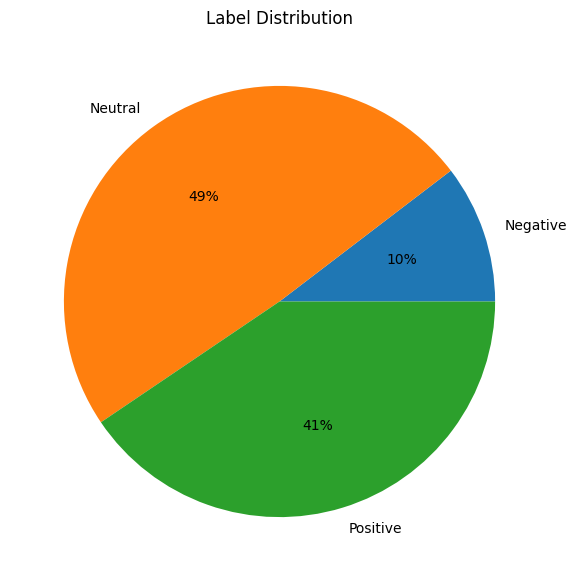

In [11]:
# Pie chart for label distribution

# map the numbers to text-labels
label_mapping = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
df2['label'] = df2['label'].map(label_mapping)

# get unique lables and frequency
labels=df2['label'].to_list()
label_ids, counts=np.unique(labels, return_counts=True)

# plot pie chart
plt.figure(figsize=(7,7))
plt.pie(counts, labels=label_ids, autopct='%.0f%%')
plt.title("Label Distribution")
plt.show()

C:\Users\shahz\AppData\Local\Temp\ipykernel_3436\1955398722.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x='label', palette="mako")


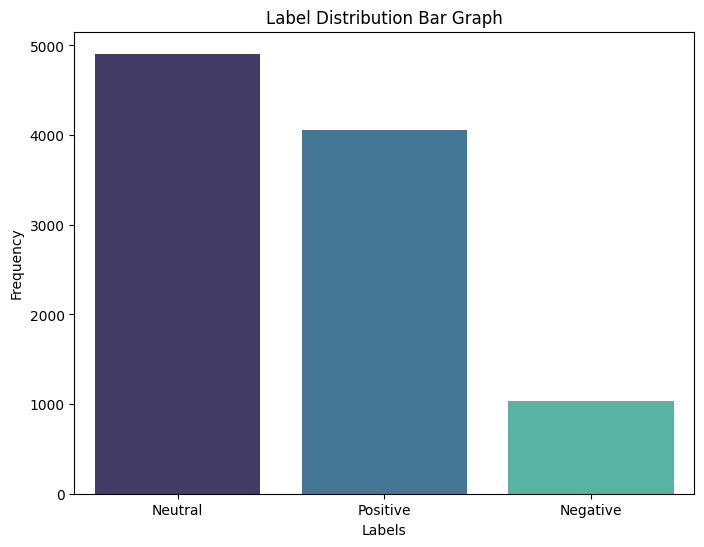

In [12]:
# Distribution of 'label' column using Bar Graph

plt.figure(figsize=(8, 6))
plt.title('Label Distribution Bar Graph')
plt.xlabel('Labels')
plt.ylabel('Frequency')
sns.countplot(data=df2, x='label', palette="mako")
plt.show()

C:\Users\shahz\AppData\Local\Temp\ipykernel_3436\2030020724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['text_length_words'] = df2['safe_text'].apply(lambda x: len(x.strip().split(" ")))


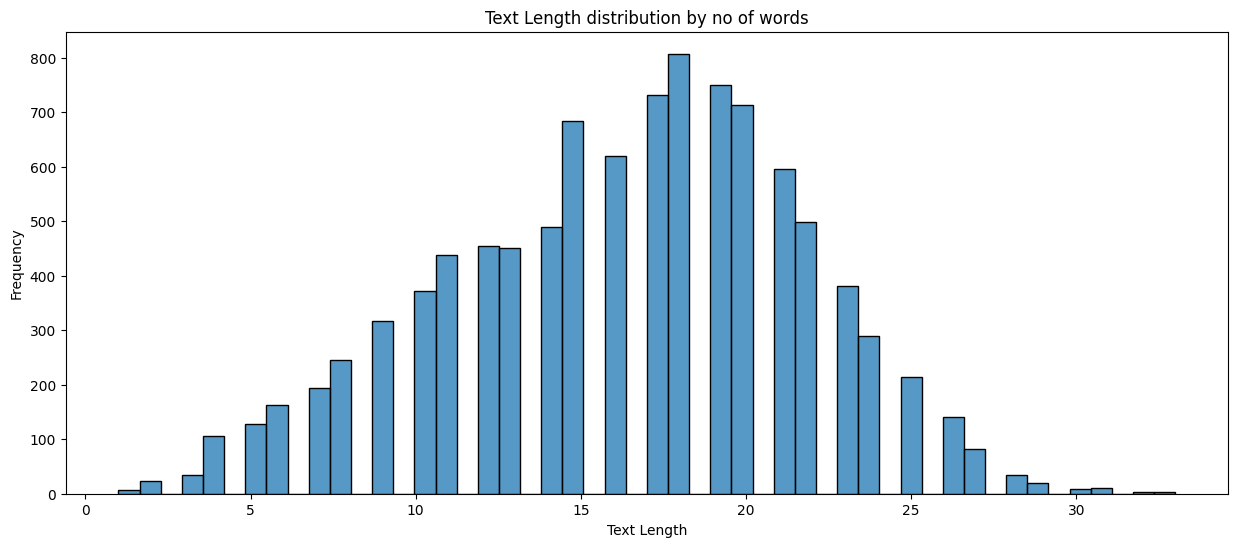

In [13]:
# visualize length of tweets based on number of words

df2['text_length_words'] = df2['safe_text'].apply(lambda x: len(x.strip().split(" ")))

plt.figure(figsize=(15, 6))
sns.histplot(df2['text_length_words'], bins=50)
plt.title("Text Length distribution by no of words")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

From the graph, tweet length varies from 1 and till 35.<br>
The tweet lengths are maximum in frequency for length of 16-17.<br>

C:\Users\shahz\AppData\Local\Temp\ipykernel_3436\976444142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['text_length_char'] = df2['safe_text'].apply(len)


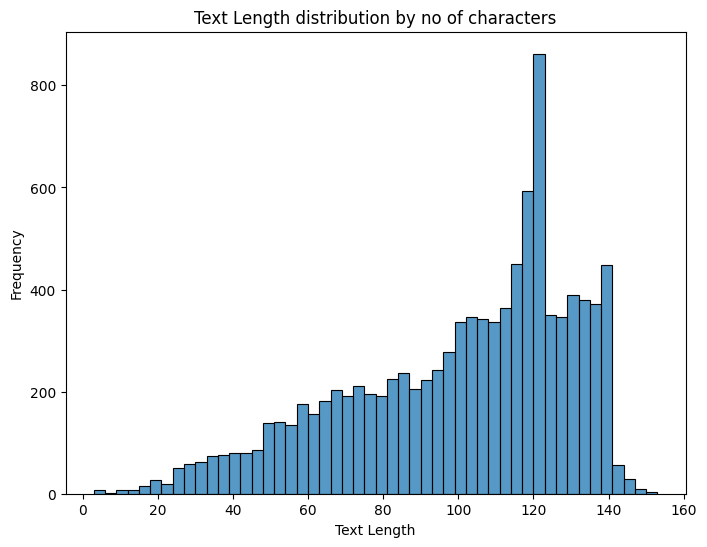

In [14]:
# visualize length of text based on number of characters

df2['text_length_char'] = df2['safe_text'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(df2['text_length_char'], bins=50)
plt.title("Text Length distribution by no of characters")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

The lengths varies from 1 to 160 and maximum frequency occur around 120.

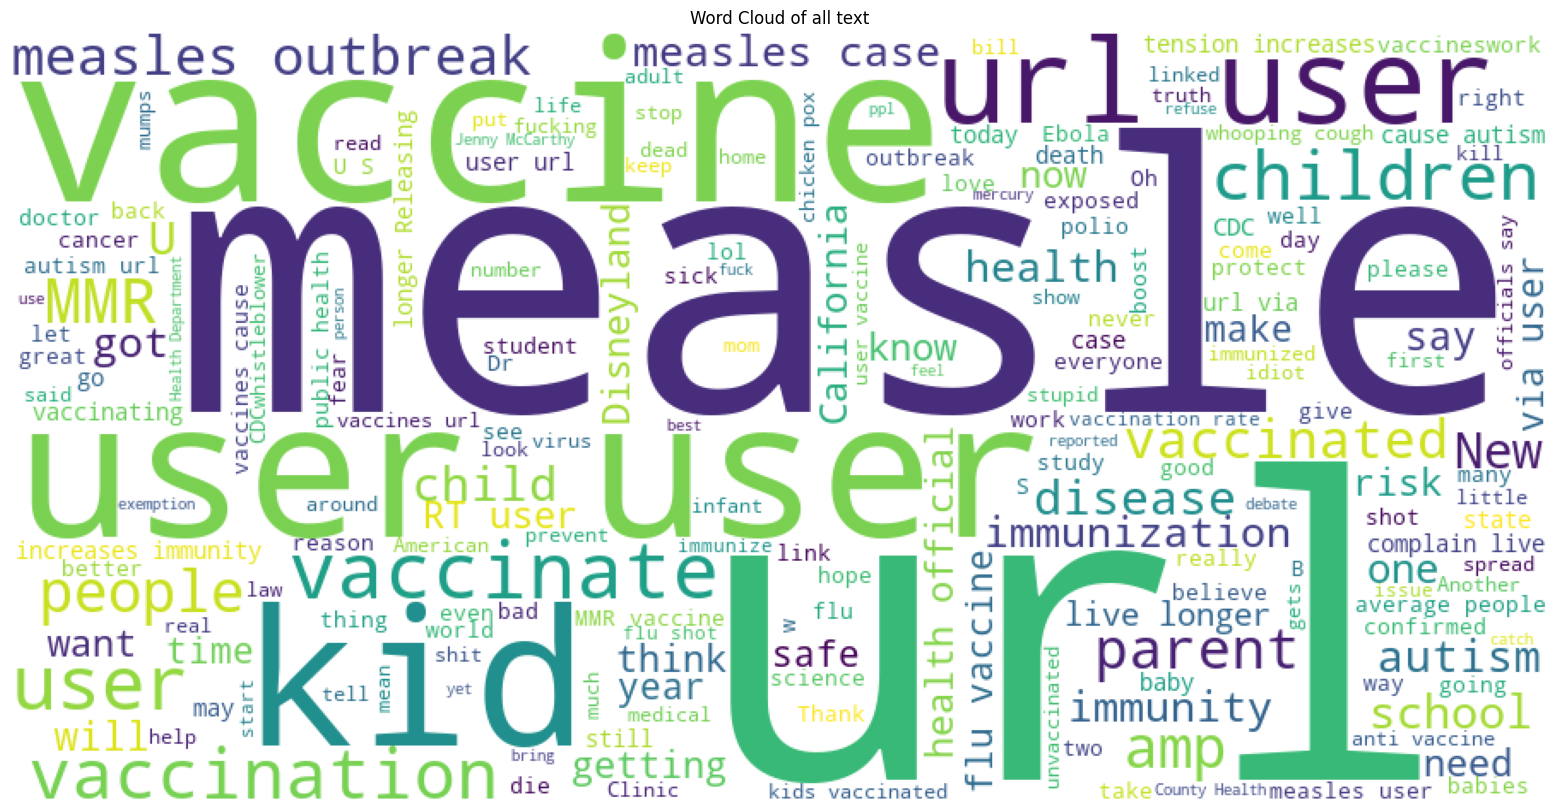

In [15]:
# Word cloud from the dataset text

# generate the wordcloud
wordcloud = WordCloud(width=900, height=450, background_color='white').generate(' '.join(df2['safe_text']))

# plot the wordcloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.title("Word Cloud of all text")
plt.axis('off')
plt.show()

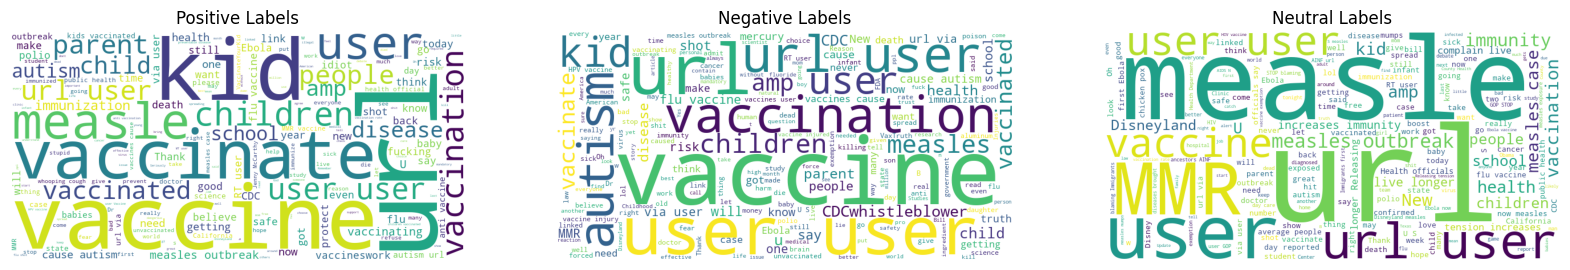

In [16]:
# wordcloud for positive, negative and neutral labelled text in dataset

# positve labelled data
df3 = df2[df2.label=="Positive"]
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df3['safe_text']))

# negative labelled data
df3 = df2[df2.label=="Negative"]
wordcloud_2 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df3['safe_text']))

# neutral labelled data
df3 = df2[df2.label=="Neutral"]
wordcloud_3 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df3['safe_text']))

# plot each wordcloud 
_,ax = plt.subplots(1,3, figsize=(20,20))
ax=ax.ravel()
ax[0].imshow(wordcloud_1)
ax[0].set_title("Positive Labels")
ax[0].axis('off')

ax[1].imshow(wordcloud_2)
ax[1].set_title("Negative Labels")
ax[1].axis('off')

ax[2].imshow(wordcloud_3)
ax[2].set_title("Neutral Labels")
ax[2].axis('off')

plt.show()

C:\Users\shahz\AppData\Local\Temp\ipykernel_3436\1317059428.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_hashtags.keys()), y=list(top_hashtags.values()), palette='magma')


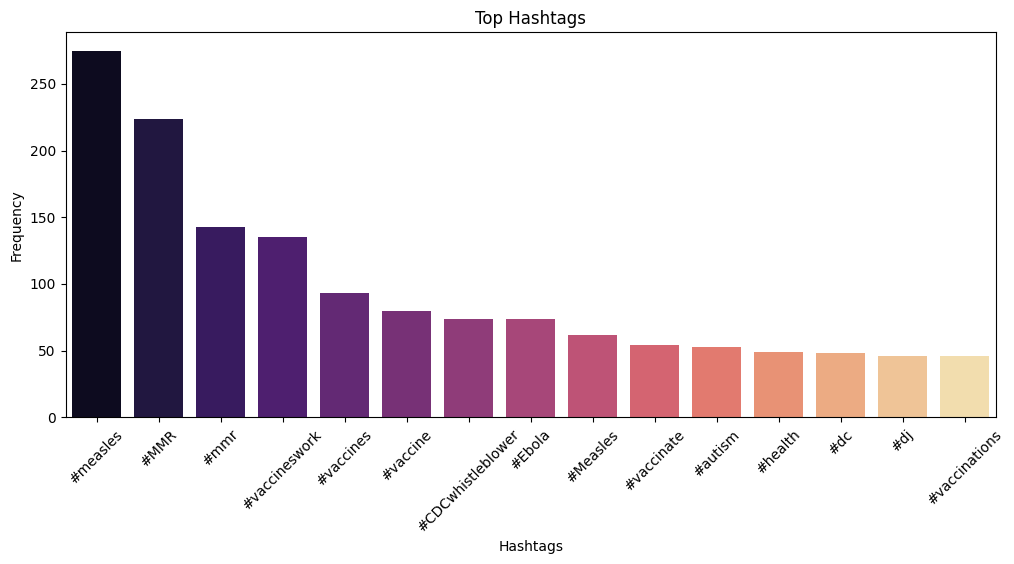

In [17]:
# get top trends/hashtags from the text(data originally from twitter)

# get hashtags from text data
hashtag_list = df2['safe_text'].str.findall(r'#\w+')

# get a single list of hashtags
hashtags = [item for sublist in hashtag_list for item in sublist]

# get hashtag frequency
hashtag_dict = Counter(hashtags)

# Get top hashtags
top_hashtags = dict(hashtag_dict.most_common(15))

# bar plot to visualize the top hashtags
plt.figure(figsize=(12, 5))
sns.barplot(x=list(top_hashtags.keys()), y=list(top_hashtags.values()), palette='magma')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top Hashtags')
plt.xticks(rotation=45)
plt.show()

# Data Prepare

In [18]:
# change emojis to text
# like :-) symbolizes 'happy'

text_emoji_map={':-)': 'happy', ':)': 'happy', ':-]': 'happy', ':]': 'happy', ':->': 'happy', ':>': 'happy', '8-)': 'happy', 
                '8)': 'happy', ':-}': 'happy', ':}': 'happy', ':o)': 'happy', ':c)': 'happy', ':^)': 'happy', '=]': 'happy', 
                '=)': 'happy', ":'-)": 'happy', ":')": 'happy', ':"D': 'happy', ':-D': 'laugh', ':D': 'laugh', '8-D': 'laugh', 
                '8D': 'laugh', '=D': 'laugh', '=3': 'laugh', 'B^D': 'laugh', 'c:': 'laugh', 'C:': 'laugh', 'x-D': 'laugh', 'xD': 
                'laugh', 'X-D': 'laugh', 'XD': 'laugh', ':-))': 'very happy', ':-(': 'sad', ':(': 'sad', ':-c': 'sad', ':c': 'sad', 
                ':-<': 'sad', ':<': 'sad', ':-[': 'sad', ':[': 'sad', ':-||': 'sad', '>:[': 'sad', ':{': 'sad', ':@': 'sad', 
                ';(': 'sad', ":'-(": 'cry', ":'(": 'cry', ':=(': 'cry', "D-':": 'horror', 'D:<': 'horror', 'D:': 'horror', 
                'D8': 'horror', 'D;': 'horror', 'D=': 'horror', 'DX': 'horror', ':-O': 'surprise', ':O': 'surprise', ':-o': 'surprise', 
                ':o': 'surprise', ':-0': 'surprise', '8-0': 'surprise', '>:O': 'surprise', '=O': 'surprise', '=o': 'surprise', '=0': 
                'surprise', ':-*': 'kiss', ':*': 'kiss', ':×': 'kiss', ':-P': 'playful', ':P': 'playful', 'X-P': 'playful', 
                'XP': 'playful', 'x-p': 'playful', 'xp': 'playful', ':-p': 'playful', ':p': 'playful', ':-Þ': 'playful', 
                ':Þ': 'playful', ':-þ': 'playful', ':þ': 'playful', ':-b': 'playful', ':b': 'playful', 'd:': 'playful', 
                '=p': 'playful', '>:P': 'playful', ':-/': 'skeptical', ':/': 'skeptical', ':-.': 'skeptical', '>:\\': 'skeptical', 
                '>:/': 'skeptical', ':\\': 'skeptical', '=/': 'skeptical', '=\\': 'skeptical', ':L': 'skeptical', '=L': 'skeptical', 
                ':S': 'skeptical', ':$': 'embarass', '://)': 'embarass', '://3': 'embarass'}


# function to change emoji to text
def convert_emoji_to_text(text):
    text=text.lower()
    for text_emoji, mood in text_emoji_map.items():    # text emoji
        text=text.replace(text_emoji, " "+mood+" ")

    text=emoji.demojize(text)                          # graphical emoji
    text=text.replace("::", " ")
    text=text.replace("_", " ")

    return text

In [19]:
# text preprocessing functions

# text cleaning function to clean text by removing unnecessary details 
def clean_text(text_orig):
    text2=text_orig

    text2=re.sub("[!:;&=\?\[\]\^\|\\,`~{}_/\(\)\"]", " ", text2)  # "text:" -> "text"
    text2=re.sub("#[a-zA-Z]*[0-9]+[a-zA-Z]*", " ", text2)         # #1256 -> ""
    text2=re.sub("[a-zA-Z0-9]*@[a-zA-Z0-9]*", " ", text2)         # acc@mail.com -> "" ; (mail id)
    text2=re.sub("[a-zA-Z0-9]*\+[a-zA-Z0-9]*", " ", text2)        # #1256 -> ""
    text2=re.sub("<[ ]*/?[ ]*[a-zA-Z]*[ ]*/?[ ]*>", " ", text2)   # <br/> -> ""
    text2=re.sub("[<>]", " ", text2)                              # "<<abc>>" -> "text"
    text2=re.sub("\*", " ", text2)                                # "beta***" -> "beta"
    text2=re.sub("#", "", text2)                                  # "sh#" -> "sh"
    text2=re.sub("\-", "", text2)                                 # "un-clear" -> "unclear"
    text2=re.sub("\.", "", text2)                                 # "Dr."" -> "Dr"
    text2=text2.replace("\\", " ")                                # "\x01"" -> "x01"

    text2=re.sub("\$[0-9]+[a-zA-Z]*", " ", text2)                 # $1256 -> ""   ; (money)
    text2=re.sub("\$", " ", text2)                                # "$" -> ""

    text2=re.sub("[0-9]*%", " ", text2)                           # 85% -> ""   ; 
    text2=re.sub("%", " ", text2)                                 # "%" -> ""

    text2=re.sub("n't", " not", text2)                            # wasn't -> was not
    text2=re.sub("'t", " not", text2)                             # have't -> spell mistake
    text2=re.sub("'[ ]*am( |$)", " ", text2)                      # 'am ' am -> ""
    text2=re.sub("'[a-zA-Z0-9]([ ]+|$)", " ", text2)              # '[a-zA-Z] -> 0 ; ('s)
    text2=re.sub("'[a-zA-Z0-9][a-zA-Z0-9]([ ]+|$)", " ", text2)   # '[a-zA-Z][a-zA-Z] -> 0 ; ('ve)
    text2=re.sub("'", " ", text2)                                 # "beta'''" -> "beta"

    text2=re.sub(r'[^\x00-\x7F]+',' ', text2)                     # remove non-ascii characters
    text2=re.sub(r'[^\w ]', '', text2)                            # remove non-words ; \x01 \x08

    text2=re.sub(r"(^[a-zA-Z] )|( [a-zA-Z]$)|(\b[a-zA-Z]\b)", " ", text2)       # I -> ""   
    text2=re.sub("([ ]*|^)[0-9]+([ ]*|^)", " ", text2)            # 5845 -> ""   

    text2=text2.strip()

    return text2


# function to tokenize text
def tokenise_text(text):
    return word_tokenize(text)

# function to remove stopwords
def stopwords_removal(tokenized_text):  
    tokenized_text_2=tokenized_text.copy()

    sw=stopwords.words('english')
    excep=[ 'against', 'above', 'below', 'up', 'down', 'on', 'off', 'over', 'under', 'all', 
        'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'no', 'nor', 'not' ]
    for word in tokenized_text:
        if word in excep:
            continue

    if word in sw:
        tokenized_text_2.remove(word)

    return tokenized_text_2


# function to lemmtize text
def lemmatize_text(tokenized_text):
    ps = PorterStemmer()
    tokenized_text_2=[ps.stem(word) for word in tokenized_text ]

    return tokenized_text_2

In [20]:
# function to preprocess text with above functions

def preprocess_text(text):
    text=text.lower()

    text=convert_emoji_to_text(text)
    text=clean_text(text)
    text=tokenise_text(text)
    text=stopwords_removal(text)  
    text=lemmatize_text(text)

    text=' '.join(text)
    return text


In [21]:
# function to do pre-processing of the text data of both train and val and finally splitting data with labels

def preprocess_corpus(df_train, df_val):

    train_X=[]
    train_Y=[]
    val_X=[]
    val_Y=[]
    
    for _, row in tqdm(df_train.iterrows()):   
        try: 
            text=row['safe_text']
            sentiment=row['label']
            pr_text=preprocess_text(text)

            train_X.append(pr_text)
            train_Y.append(sentiment)
        except:
            pass

    for _, row in tqdm(df_val.iterrows()):
        try:
            text=row['safe_text']
            sentiment=row['label']
            pr_text=preprocess_text(text)

            val_X.append(pr_text)
            val_Y.append(sentiment)
        except:         
            pass

    return (train_X, train_Y, val_X, val_Y)



Load the labelled dataset for train/validation using already split train/val csv files from original Train.csv

In [22]:
# get the train/val data set, drop null values rows to train the model.

df_train = pd.read_csv("data/train_subset.csv")
df_val = pd.read_csv("data/eval_subset.csv")

df_train = df_train.dropna()
df_val = df_val.dropna()

df_train.shape, df_val.shape

((7999, 5), (2000, 5))

In [23]:
df_train.head()

,tweet_id,safe_text,label,agreement,tweet_length
0,YMRMEDME,Mickey's Measles has gone international <url>,Neutral,1.000000,45
1,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,Neutral,1.000000,122
2,EI10PS46,<user> your ignorance on vaccines isn't just ...,Positive,0.666667,118
3,OM26E6DG,Pakistan partly suspends polio vaccination pro...,Neutral,1.000000,93
4,NBBY86FX,In other news I've gone up like 1000 mmr,Neutral,1.000000,40


In [24]:
# map the labels to numeric one

mapping = {'Positive':1 , 'Negative': -1, "Neutral":0}
df_train['label'] = df_train['label'].map(mapping)
df_val['label'] = df_val['label'].map(mapping)

In [25]:
df_train.head()

,tweet_id,safe_text,label,agreement,tweet_length
0,YMRMEDME,Mickey's Measles has gone international <url>,0,1.000000,45
1,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0,1.000000,122
2,EI10PS46,<user> your ignorance on vaccines isn't just ...,1,0.666667,118
3,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0,1.000000,93
4,NBBY86FX,In other news I've gone up like 1000 mmr,0,1.000000,40


In [26]:
df_val.head()

,tweet_id,safe_text,label,agreement,tweet_length
0,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1,1.000000,61
1,2DD250VN,<user> no. I was properly immunized prior to t...,1,1.000000,102
2,ESEVBTFN,<user> thx for posting vaccinations are impera...,1,1.000000,120
3,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1,0.666667,69
4,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1,1.000000,118


In [27]:
# Process corpus data
# Following function will process the tweets using above functions 

train_corpus, train_sent, test_corpus, test_sent= preprocess_corpus(df_train, df_val)

# train_corpus and test_corpus are the processed tweets while the train_sent and test_sent - 
# are the sentiment labels in numerical form

len(train_corpus), len(train_sent), len(test_corpus), len(test_sent)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(7999, 7999, 2000, 2000)

In [28]:
# Feature vectorization using TF-IDF vectorizer

vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(train_corpus)
X_test_vectors = vectorizer.transform(test_corpus)

In [29]:
# get the shape of the dataset
X_train_vectors.shape, X_test_vectors.shape

((7999, 9249), (2000, 9249))

There are 7998 samples for the train data and 2001 samples for test data.<br>
Vocabulary is of size 9292 in the dataset.

# Train model

 **Multinomial Naive Bayes**

In [30]:
# Train a Multinomial Naive Bayes classifier

clf = MultinomialNB()
clf.fit(X_train_vectors, train_sent)

# Predictions
y_pred = clf.predict(X_test_vectors)

# Evaluate the model
clf_accuracy = accuracy_score(test_sent, y_pred)
print("Naive Bayes Accuracy:", clf_accuracy)

Naive Bayes Accuracy: 0.696


**Support Vector Machine** 

In [31]:
# Support Vector Machine classifier (linear kernel)
svc_clf = SVC(kernel='linear')
svc_clf.fit(X_train_vectors, train_sent)

# Predictions
y_pred = svc_clf.predict(X_test_vectors)

# Evaluate the model
svm_accuracy = accuracy_score(test_sent, y_pred)
print("SVM (Linear kernel) Accuracy:", svm_accuracy)


# **********************************************

# Support Vector Machine classifier (RBF kernel)
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train_vectors, train_sent)
svm_pred = svm_clf.predict(X_test_vectors)
svm_accuracy = accuracy_score(test_sent, svm_pred)
print("SVM (RBF Kernel) Accuracy:", svm_accuracy)

SVM (Linear kernel) Accuracy: 0.7315
SVM (RBF Kernel) Accuracy: 0.729


**Tree based algorithms**

In [32]:
# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train_vectors, train_sent)
dt_pred = dt_clf.predict(X_test_vectors)
dt_accuracy = accuracy_score(test_sent, dt_pred)
print("Decision Tree Accuracy:", dt_accuracy)

# ***************************************

# Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_vectors, train_sent)
rf_pred = rf_clf.predict(X_test_vectors)
rf_accuracy = accuracy_score(test_sent, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

Decision Tree Accuracy: 0.6695
Random Forest Accuracy: 0.7175


**KNN Classifier**

In [33]:
# K-Nearest Neighbors (KNN)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_vectors, train_sent)
knn_pred = knn_clf.predict(X_test_vectors)
knn_accuracy = accuracy_score(test_sent, knn_pred)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.668


# Compare ML models

In [34]:
# create a final dataframe with model names and their accuracy.

model_names = [ "Naive Bayes", "SVM (Linear)", "SVM (RBP)", "Decision Tree", "Random Forest", "KNN" ]
acc_list = [ clf_accuracy, 0.7315, 0.729, dt_accuracy, rf_accuracy, knn_accuracy ]

df_metrics = pd.DataFrame({"Model": model_names, "Accuracy":acc_list})
df_metrics

,Model,Accuracy
0,Naive Bayes,0.6960
1,SVM (Linear),0.7315
2,SVM (RBP),0.7290
3,Decision Tree,0.6695
4,Random Forest,0.7175
5,KNN,0.6680


**SVM with linear kernel** is the winner in this case with greater accuracy in sentiment analysis